[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")]()

### Colab link to follow

In [ ]:
#| default_exp gridding_utils.polygon_fill

In [ ]:
#| export
from typing import List, Tuple, Set, Optional, Dict, Union

import numpy as np
import pandas as pd
import polars as pl

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Overview

We will use 2 separate algorithms for filling in pixels in polygons.
1. [Voxel Traversal Algorithm](https://github.com/cgyurgyik/fast-voxel-traversal-algorithm/blob/master/overview/FastVoxelTraversalOverview.md): We use this for filling in pixels along the polygon boundary. We implement 2D voxel traversal for every line segment of the polygon boundary.
2. [Scanline Fill Algorithm](https://www.educative.io/answers/what-is-scanline-fill-algorithm): We use this for filling in pixels in the polygon interior.

All pixels and polygon vertices are assumed to have nonnegative integer coordinates

In [ ]:
#| hide
polygon_test_cases = {
    "Square": [(0, 0), (10, 0), (10, 10), (0, 10)],
    "Triangle": [(0, 0), (10, 0), (5, 10)],
    "Right Triangle": [(0, 0), (10, 0), (0, 10)],
    "Pentagon": [(2, 0), (8, 0), (10, 6), (5, 10), (0, 6)],
    "Star": [
        (6, 2),
        (8, 8),
        (12, 8),
        (9, 12),
        (11, 18),
        (6, 14),
        (1, 18),
        (3, 12),
        (0, 8),
        (4, 8),
    ],

    "Complex Shape 1": [(0, 0), (5, 2), (3, 5), (8, 8), (5, 10), (0, 7)],
    "Complex Shape 2": [
        (0, 0),
        (2, 6),
        (4, 10),
        (6, 8),
        (8, 12),
        (10, 4),
        (12, 2),
        (8, 0),
    ],
    "Complex Shape 3": [(2, 3), (5, 3), (6, 6), (3, 7), (1, 5)],
    "Complex Shape 4": [(1, 1), (2, 5), (4, 3), (6, 7)],
    "Complex Shape 5": [(1, 2), (3, 6), (5, 5), (7, 4), (9, 5), (11, 2)],
}

In [ ]:
#| hide
def plot_polygon(
    ax: plt.Axes,
    vertices: List[Tuple[int,int]],
    pixels: Optional[set] = None,
    figsize: tuple = (4, 4),
):
    vertices_x = [x for (x,y) in vertices]
    vertices_y = [y for (x,y) in vertices]
    
    ax.plot(vertices_x, vertices_y, "b-", markersize=5)
    # to close off the polygon
    ax.plot([vertices_x[-1], vertices_x[0]], [vertices_y[-1], vertices_y[0]], "b-")

    if pixels is not None:
        for x, y in pixels:
            rect = patches.Rectangle(
                xy=(x - 0.5, y - 0.5),
                width=1,
                height=1,
                linewidth=1,
                edgecolor="black",
                facecolor="r",
                alpha=0.6,
            )
            ax.add_patch(rect)

def plot_all_polygons(
    polygon_vertices_dict: Dict[str, List[Tuple[int, int]]], 
    polygon_pixels_dict: Dict[str, set], 
    n_imgs_per_row: int = 3,
):
    n = len(polygon_vertices_dict)
    rows = (n + n_imgs_per_row - 1) // n_imgs_per_row  # Calculate the number of rows needed
    fig, axes = plt.subplots(nrows=rows, ncols=n_imgs_per_row, figsize=(4 * n_imgs_per_row, 4 * rows))

    if n_imgs_per_row == 1:
        axes = [axes]  
    
    # Flattening the axes for easier iteration, especially for n_imgs_per_row = 1
    axes_flat = axes.flatten()

    # Iterate over each polygon and its corresponding pixels
    for ax, (name, vertices) in zip(axes_flat, polygon_vertices_dict.items()):
        pixels = polygon_pixels_dict.get(name, set())  # Safely get pixels for the polygon
        plot_polygon(ax, vertices, pixels)
        ax.set_title(name)
        ax.axis('equal')  # Ensure the aspect ratio is equal to properly display polygons
    
    # Turn off any unused axes
    for ax in axes_flat[n:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## Voxel Traversal

We use the 2D voxel traversal algorithm to fill in pixels between two points.

In [ ]:
#| export

# epsilon is a constant for correcting near-misses in voxel traversal
EPSILON = 1e-14

def voxel_traversal_2d(
    start_vertex: Tuple[int, int], 
    end_vertex: Tuple[int, int],
    debug: bool = False, # if true, prints diagnostic info for the algorithm  
) -> List[Tuple[int, int]]:
    """Returns all pixels between two points as inspired by Amanatides & Woo's “A Fast Voxel Traversal Algorithm For Ray Tracing” """

    # Setup initial conditions
    x1, y1 = start_vertex
    x2, y2 = end_vertex

    direction_x = 1 if x2 > x1 else -1
    direction_y = 1 if y2 > y1 else -1

    if (x1 == x2) and (y1 == y2):
        raise ValueError(
            f"start_vertex {start_vertex} and end_vertex {end_vertex} are the same"
        )

    # Vertical line
    elif x1 == x2:
        pixels = [(x1, y) for y in range(y1, y2 + direction_y, direction_y)]
        return pixels

    # Horizontal line
    elif y1 == y2:
        pixels = [(x, y1) for x in range(x1, x2 + direction_x, direction_x)]
        return pixels

    dy = y2 - y1
    dx = x2 - x1
    slope = dy / dx
    inv_slope = dx / dy

    # reverse order if negative slope to preserve symmetry in floating point calculations
    if slope < 0:
        x1, y1 = end_vertex
        x2, y2 = start_vertex

        direction_x = 1 if x2 > x1 else -1
        direction_y = 1 if y2 > y1 else -1

    slope_multiplier = np.sqrt(1 + slope**2)
    inv_slope_multiplier = np.sqrt(1 + inv_slope**2)

    pixel_x, pixel_y = x1, y1
    ray_x, ray_y = pixel_x, pixel_y
    pixels = [(pixel_x, pixel_y)]

    is_finished = False

    if debug:
        print(f"\nTraversing from ({x1},{y1}) to ({x2},{y2})")

    # number of steps should not exceed the perimeter of the rectangle enclosing the line segment
    max_steps = 2 * (abs(dx) + abs(dy))
    n_steps = 0
    while not is_finished:
        # this prevents infinite loops
        n_steps += 1
        if n_steps > max_steps:
            raise Exception(
                f"Traversal has exceeded steps limit {max_steps:,}. Please recheck inputs"
            )

        # get the next x or y integer that the next ray would hit
        if direction_x == 1:
            next_ray_x = np.floor(ray_x) + 1
        elif direction_x == -1:
            next_ray_x = np.ceil(ray_x) - 1

        if direction_y == 1:
            next_ray_y = np.floor(ray_y) + 1
        elif direction_y == -1:
            next_ray_y = np.ceil(ray_y) - 1

        # get distance between the 2 candidates and check which one is closer
        # there is an epsilon to account near-misses due to floating point differences

        # y coordinate line formula is next_ray_y = ray_y + slope*(next_ray_x-ray_x)
        # squred distance is (next_ray_x - ray_x)**2 + (slope*(next_ray_x-ray_x))**2
        # distance simplifies to abs(next_ray_x - ray_x)* sqrt(1+slope**2)

        ray_candidate_1 = (
            next_ray_x,
            ray_y + slope * (next_ray_x - ray_x) + direction_y * EPSILON,
        )
        # unsimplified square distance
        # dist_1 = (ray_candidate_1[0] - ray_x)**2 + (ray_candidate_1[1] - ray_y)**2
        # simplified distance
        dist_1 = abs(next_ray_x - ray_x) * slope_multiplier

        # x coordinate line formula is next_ray_x = ray_x + inv_slope*(next_ray_y-y)
        # squared distance is (inv_slope*(next_ray_y-ray_y))**2 + (next_ray_y-ray_y)**2
        # distance simplifies to abs(next_ray_y-ray_y)* sqrt(1 + inv_slope**2)

        ray_candidate_2 = (
            ray_x + inv_slope * (next_ray_y - ray_y) + direction_x * EPSILON,
            next_ray_y,
        )
        # unsimplified square distance
        # dist_2 = (ray_candidate_2[0] - ray_x)**2 + (ray_candidate_2[1] - ray_y)**2
        # simplified distance
        dist_2 = abs(next_ray_y - ray_y) * inv_slope_multiplier

        # candidate 1 is closer
        if dist_1 < dist_2:
            pixel_x += direction_x
            ray_x, ray_y = ray_candidate_1

        # candidate 2 is closer
        elif dist_1 > dist_2:
            pixel_y += direction_y
            ray_x, ray_y = ray_candidate_2

        # line passes exactly on the corner
        elif dist_1 == dist_2:
            pixel_x += direction_x
            pixel_y += direction_y
            ray_x, ray_y = pixel_x, pixel_y
        else:
            raise ValueError(f"Erroneous distances {dist_1}, {dist_2}")

        if debug:
            print(
                f"Next ray coords are ({ray_x}, {ray_y}) and tile coords are ({pixel_x}, {pixel_y})"
            )

        pixels.append((pixel_x, pixel_y))

        # checks to see if the loop is finished
        if direction_x == 1:
            is_x_finished = pixel_x >= x2
        elif direction_x == -1:
            is_x_finished = pixel_x <= x2

        if direction_y == 1:
            is_y_finished = pixel_y >= y2
        elif direction_y == -1:
            is_y_finished = pixel_y <= y2

        if is_x_finished and is_y_finished:
            break

    return pixels

We use voxel traversal on every line segment to fill the polygon boundary.

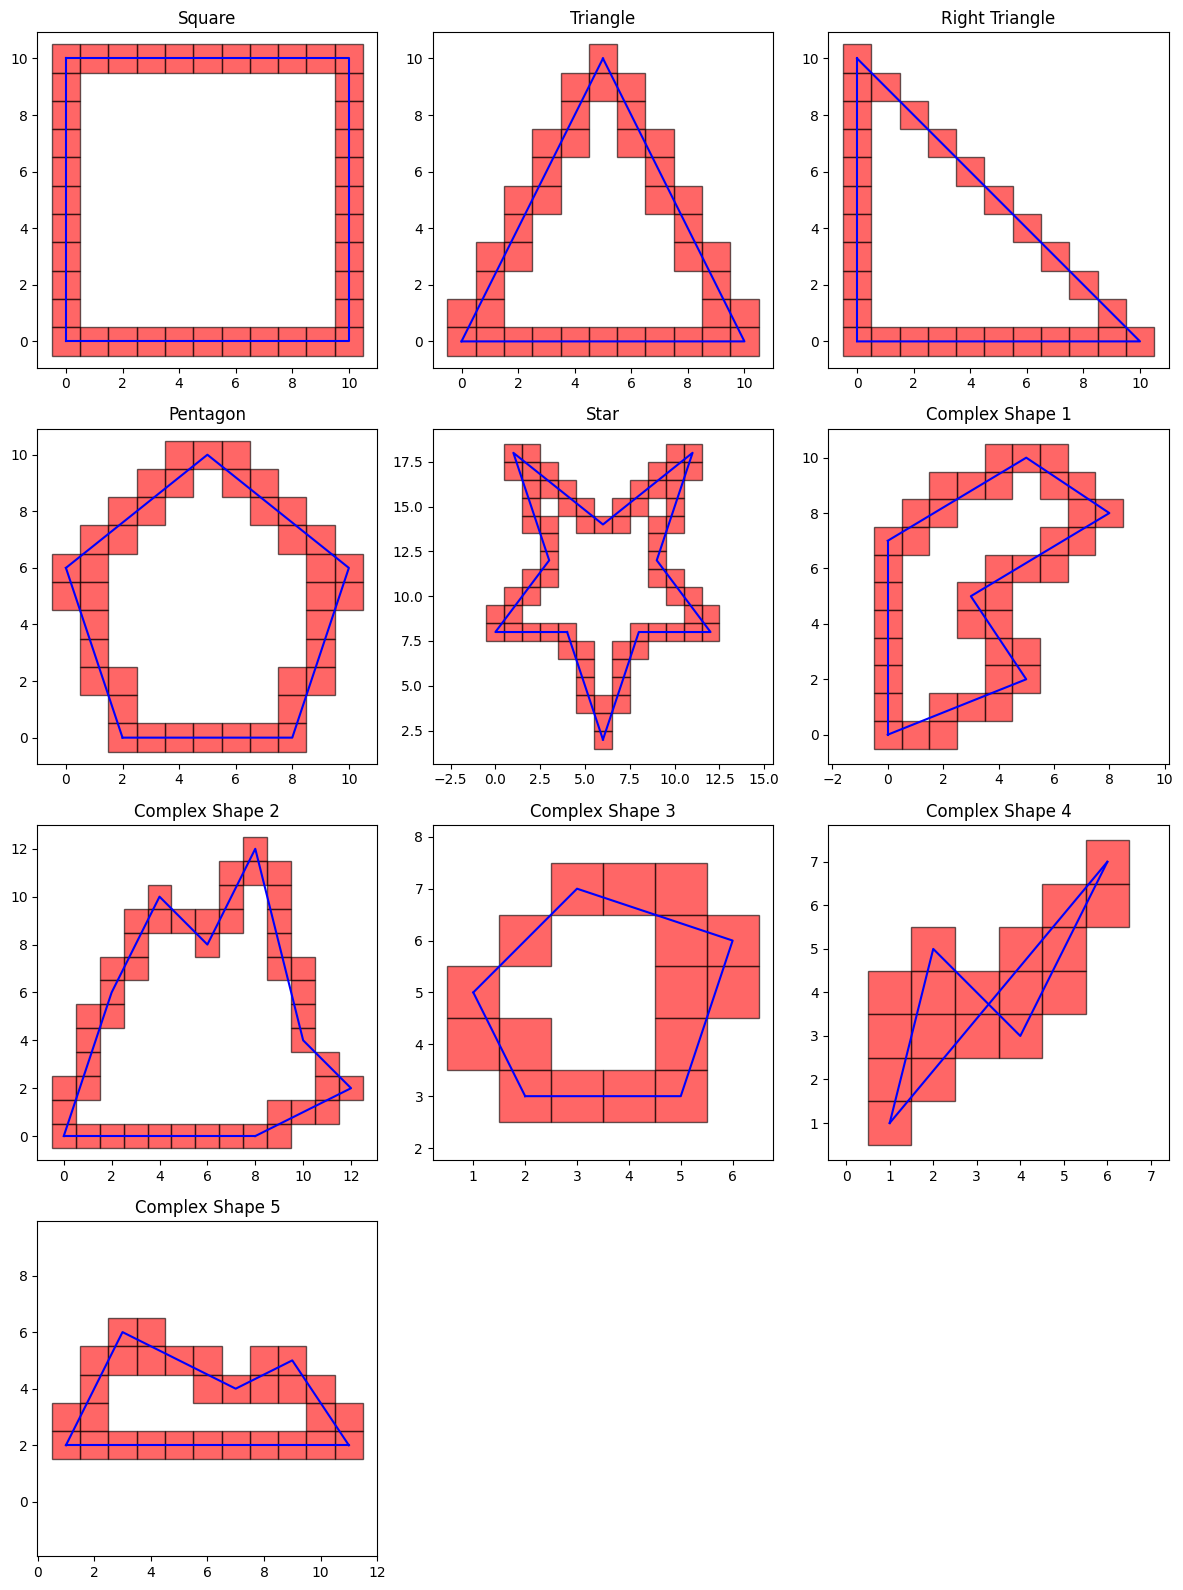

In [ ]:
polygon_pixels = {}
for test_polygon_name, vertices in polygon_test_cases.items():
    offset_vertices = vertices[1:] + vertices[:1]

    pixels = set()
    for start_vertex, end_vertex in zip(vertices, offset_vertices):
        pixels.update(voxel_traversal_2d(start_vertex, end_vertex))

    polygon_pixels[test_polygon_name] = pixels
    
plot_all_polygons(polygon_test_cases, polygon_pixels)

## Scanline Fill Algorithm

We use the scanline fill algorithm to fill in pixels within the polygon boundary.

In [ ]:
#| export
def scanline_fill(
    vertices: List[Tuple[int,int]], # list of polygon vertices in order (either clockwise or counterclockwise)
    debug: bool = False, # if true, prints diagnostic info for the algorithm  
) -> Set[Tuple[int,int]]:
    """Returns all pixels within the interior of a polygon defined by vertices"""
    
    offset_vertices = vertices[1:] + vertices[:1]

    if not vertices:
        return set()
    
    if len(vertices) == 1:
        return set(vertices)

    # Calculate the bounding box for the polygon
    min_y, max_y = min(y for x, y in vertices), max(y for x, y in vertices)

    filled_pixels = set()
    # Process each horizontal scanline within the bounding box
    for scanline_y in range(min_y, max_y + 1):
        intersection_points = []

        # Find intersections of the polygon with the current scanline
        for start_vertex, end_vertex in zip(vertices, offset_vertices):
            start_x, start_y = start_vertex
            end_x, end_y = end_vertex

            if (end_y < scanline_y <= start_y) or (start_y < scanline_y <= end_y):
                # Calculate x-coordinate of intersection
                intersection_x = interpolate_x(start_vertex, end_vertex, scanline_y)
                intersection_points.append(intersection_x)

        # Fill pixels between pairs of intersections
        if intersection_points:
            intersection_points.sort()

            filled_pixels_in_row = set()
            for start_x, end_x in zip(
                intersection_points[::2], intersection_points[1::2]
            ):
                start_x, end_x = int(round(start_x)), int(round(end_x))

                _filled_pixels_in_row = [
                    (x, scanline_y) for x in range(start_x, end_x + 1)
                ]
                filled_pixels_in_row.update(_filled_pixels_in_row)

            filled_pixels.update(filled_pixels_in_row)

        if debug:
            print(f"Scanline y = {scanline_y}, Intersections: {intersection_points}")
    
    return filled_pixels


def interpolate_x(
    start_vertex: Tuple[int, int],
    end_vertex: Tuple[int, int],
    y: int,
) -> float:
    """Interpolate x value for a given y along the line segment defined by start_vertex and end_vertex."""
    x1, y1 = start_vertex
    x2, y2 = end_vertex
    if y1 == y2:
        # case when there is a horizontal line segment
        raise ValueError(f"The y value of the 2 vertices should not be the same")

    inverse_slope = (x2 - x1) / (y2 - y1)
    interpolated_x = x1 + (y - y1) * inverse_slope
    return interpolated_x


We use scanline fill on every set of vertices. Notice that the scanline can fill parts of the boundary as well, but it doesn't capture the entire boundary.

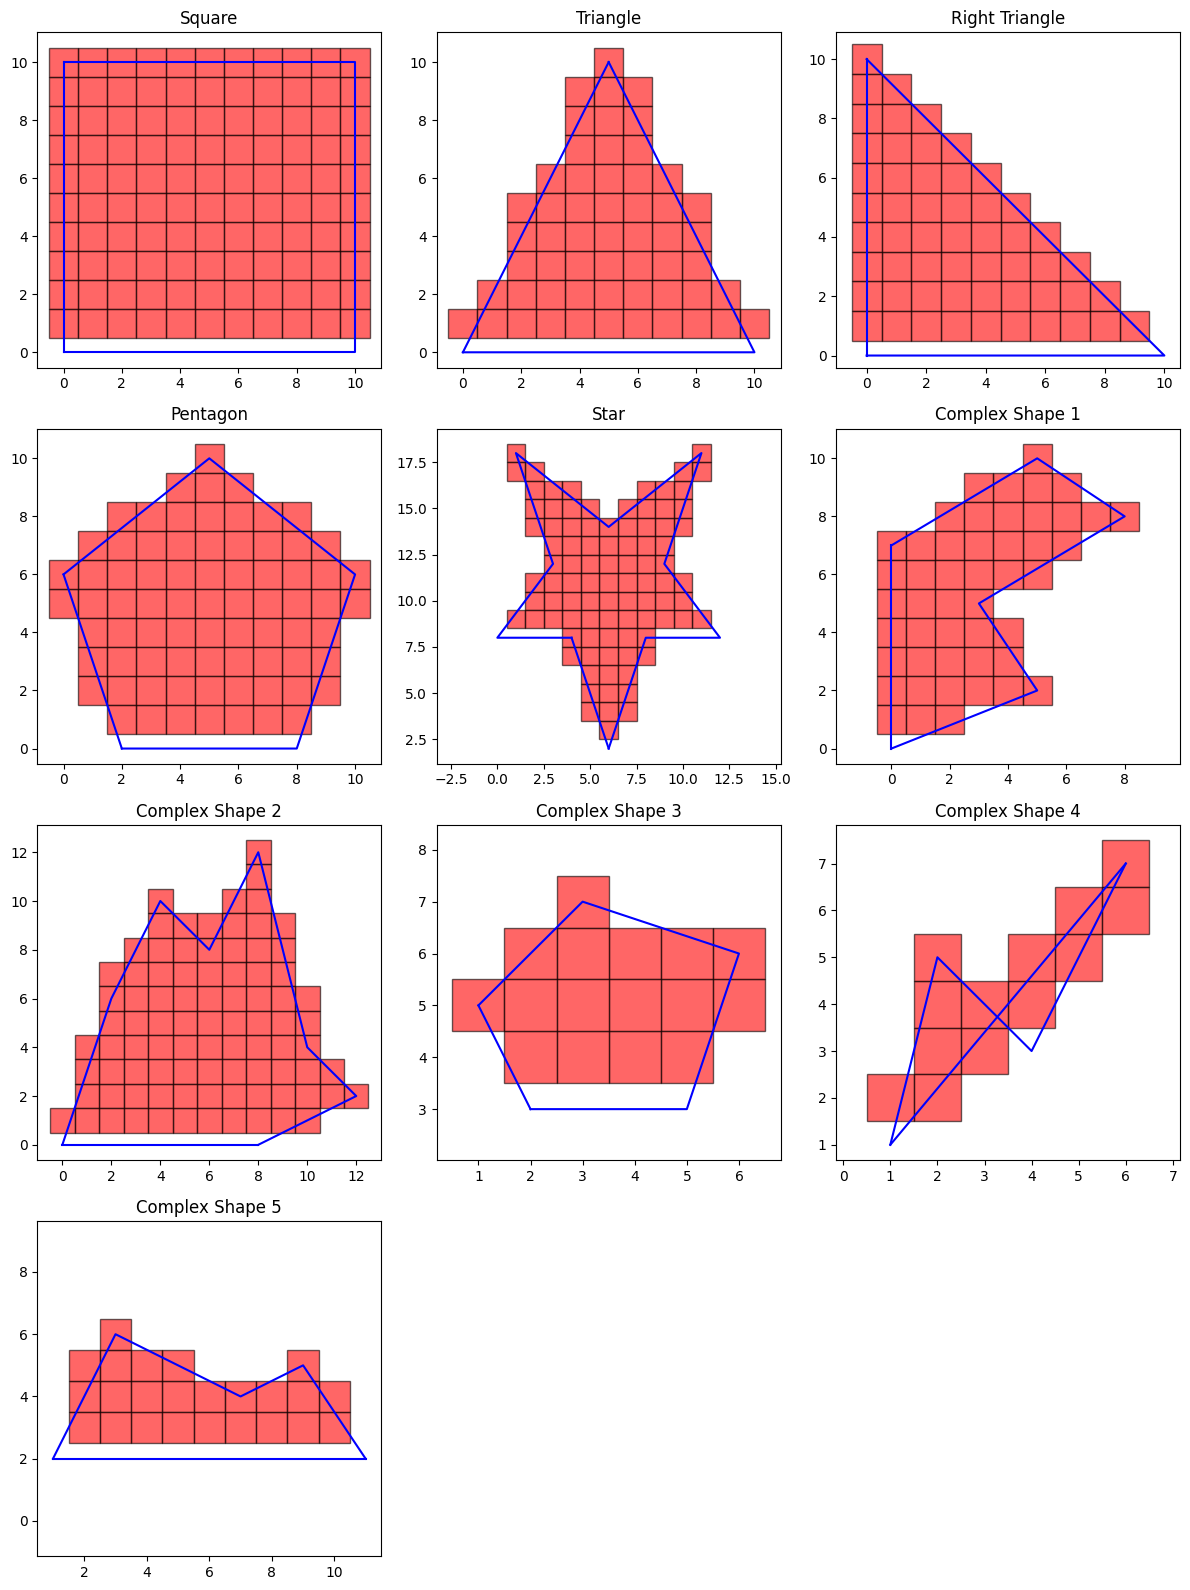

In [ ]:
polygon_pixels = {}
for test_polygon_name, vertices in polygon_test_cases.items():
    polygon_pixels[test_polygon_name] = scanline_fill(vertices)
    
plot_all_polygons(polygon_test_cases, polygon_pixels)

## Combining Voxel Traversal and Scanline Fill for our Polygon Fill Algorithm

In [ ]:
#| export

def polygon_fill(
    vertices_df: Union[pd.DataFrame,pl.DataFrame], # dataframe with x_col and y_col for the polygon vertices
    x_col: str = "x", 
    y_col: str = "y",
    debug: bool = False, # if true, prints diagnostic info for both voxel traversal and scanline fill algorithms
) -> Set[Tuple[int,int]]:
    """
    Returns pixels that intersect a polygon
    This uses voxel traversal to fill the boundary, and scanline fill for the interior. All coordinates are assumed to be nonnegative integers        
    """

    vertices = list(zip(vertices_df[x_col].to_list(), vertices_df[y_col].to_list()))
    offset_vertices = vertices[1:] + vertices[:1]

    polygon_pixels = set()
    for start_vertex, end_vertex in zip(vertices, offset_vertices):
        polygon_pixels.update(voxel_traversal_2d(start_vertex, end_vertex, debug))
        
    polygon_pixels.update(scanline_fill(vertices, debug))

    return polygon_pixels

By using both algorithms, we can fill all the pixels per polygon.

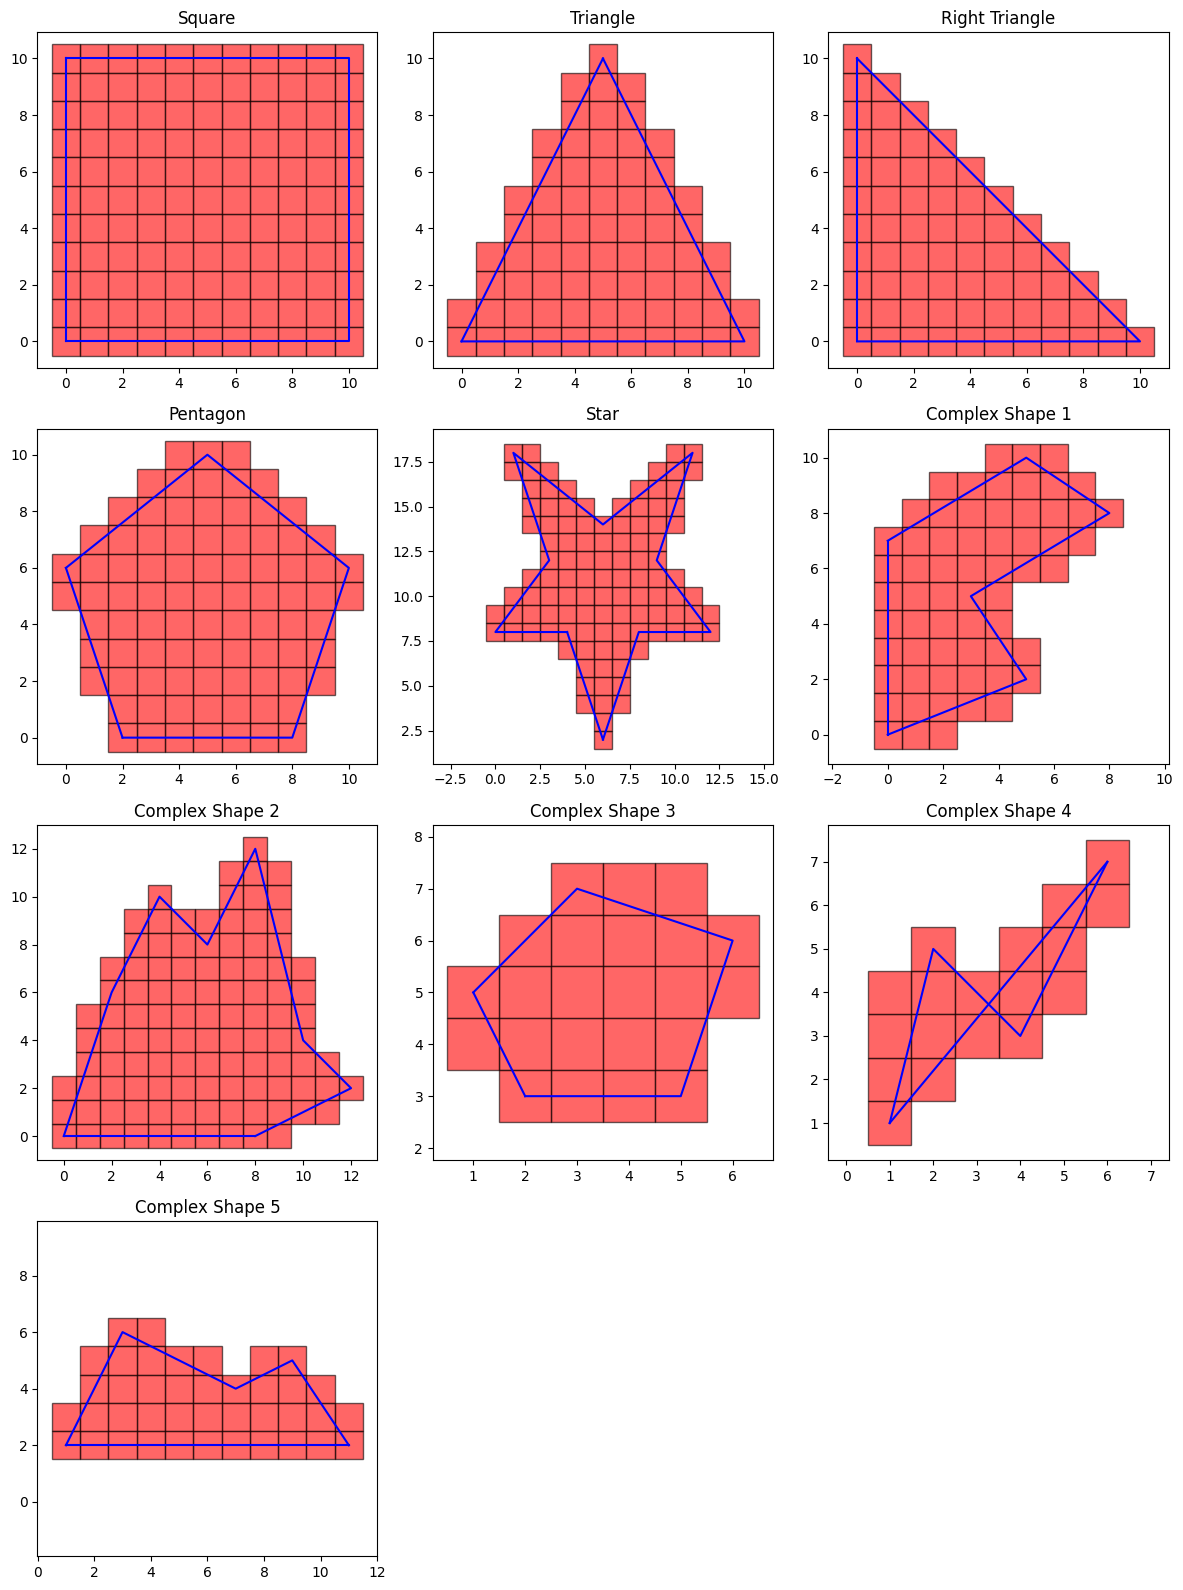

In [ ]:
polygon_pixels = {}
for test_polygon_name, vertices in polygon_test_cases.items():
    vertices_df = pd.DataFrame(vertices, columns=["x", "y"])
    polygon_pixels[test_polygon_name] = polygon_fill(vertices_df)
    
plot_all_polygons(polygon_test_cases, polygon_pixels)